# Importation des modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import pathlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

# Exploration du dataset

In [3]:
data_dir = 'PBC_dataset_normal_DIB'
data_dir = pathlib.Path(data_dir)

In [5]:
batch_size=16
img_height=360
img_width=360

In [6]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
                                            data_dir, validation_split=0.2, subset='training', seed=123,
                                            image_size=(img_height, img_width), batch_size=batch_size)

Found 17092 files belonging to 8 classes.
Using 13674 files for training.


In [7]:
validation_data = tf.keras.preprocessing.image_dataset_from_directory(
                                            data_dir, validation_split=0.2, subset='validation', seed=123,
                                            image_size=(img_height, img_width), batch_size=batch_size)

Found 17092 files belonging to 8 classes.
Using 3418 files for validation.


# EfficientNet

In [8]:
from tensorflow.keras.applications import EfficientNetB1

efficientNet = EfficientNetB1(include_top=False, input_shape=(img_height, img_width, 3))

for layer in efficientNet.layers:
    layer.trainable = False
    
efficientNet.summary()

Model: "efficientnetb1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 360, 360, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 360, 360, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 360, 360, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 360, 360, 3)  0           ['normalization[0][0

In [9]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.models import Model, Sequential, load_model

model = Sequential()

model.add(efficientNet)

model.add(GlobalAveragePooling2D())

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(8, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional)  (None, 12, 12, 1280)     6575239   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

In [10]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [11]:
logdir='logs'

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,
                                                  histogram_freq=1,
                                                  write_images=logdir, 
                                                  embeddings_data=train_data)

In [12]:
history = model.fit(train_data,
                    validation_data=validation_data, 
                    epochs=5, 
                    callbacks=[tensorboard_callback])

Epoch 1/5


C:\Users\frede\anaconda3\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


855/855 [==============================] - 1781s 2s/step - loss: 0.7140 - accuracy: 0.7448 - val_loss: 0.3497 - val_accuracy: 0.8812
Epoch 2/5
855/855 [==============================] - 1715s 2s/step - loss: 0.4359 - accuracy: 0.8485 - val_loss: 0.2568 - val_accuracy: 0.9108
Epoch 3/5
855/855 [==============================] - 1874s 2s/step - loss: 0.3677 - accuracy: 0.8758 - val_loss: 0.4039 - val_accuracy: 0.8663
Epoch 4/5
855/855 [==============================] - 1967s 2s/step - loss: 0.3315 - accuracy: 0.8864 - val_loss: 0.2657 - val_accuracy: 0.9119
Epoch 5/5
855/855 [==============================] - 2028s 2s/step - loss: 0.3094 - accuracy: 0.8957 - val_loss: 0.2346 - val_accuracy: 0.9195


In [45]:
model.evaluate(validation_data)

214/214 [==============================] - 411s 2s/step - loss: 0.2346 - accuracy: 0.9195


[0.234571173787117, 0.9195435643196106]

In [46]:
y_true_test = np.concatenate([y for x,y in validation_data])

In [47]:
y_pred = model.predict(validation_data)
y_pred_class = y_pred.argmax(axis=1)

214/214 [==============================] - 473s 2s/step


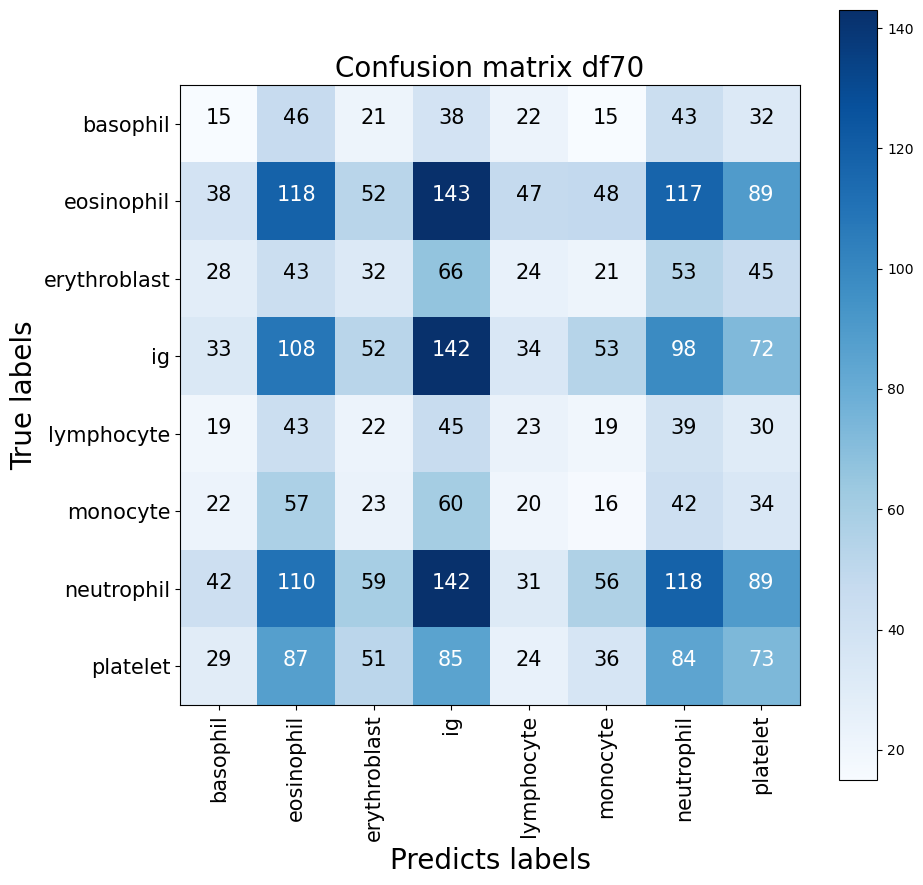

In [50]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

cnf_matrix = confusion_matrix(y_true_test, y_pred_class)

classes = train_data.class_names

plt.figure(figsize=(10,10))

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Confusion matrix df70",fontsize=20)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation =90,fontsize=15)
plt.yticks(tick_marks, classes,fontsize=15)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black",
            fontsize=15)

plt.ylabel('True labels',fontsize=20)
plt.xlabel('Predicts labels',fontsize=20)
plt.show()

In [98]:
model.save('efficientNet.h5')

TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.